# Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
from textblob import Word
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.optimizers import Adam

# Load the dataset

In [7]:
file = open("Sarcasm_Headlines_Dataset_v2.json")
json_data = [json.loads(line) for line in file]

In [38]:
json_data[0:5]

[{'is_sarcastic': 1,
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'},
 {'is_sarcastic': 0,
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'},
 {'is_sarcastic': 0,
  'headline': 'eat your veggies: 9 deliciously different recipes',
  'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html'},
 {'is_sarcastic': 1,
  'headline': 'inclement weather prevents liar from getting to work',
  'article_link': 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031'},
 {'is_sarcastic': 1,
  'headline': "mother comes pretty close to using word 'streaming' correctly",
  'article_link': 'https://www.theonion.com/mother-comes-pretty-

In [8]:
texts = []
labels = []
urls = []
for item in json_data:
    texts.append(item['headline'])
    labels.append(item["is_sarcastic"])
    urls.append(item['article_link'])


In [39]:
texts[0:10]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly",
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 "richard branson's global-warming donation nearly as much as cost of failed balloon trips",
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario']

In [40]:
labels[0:10]

[1, 0, 0, 1, 1, 0, 0, 1, 1, 0]

In [41]:
urls[0:5]

['https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205',
 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207',
 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html',
 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031',
 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546']

In [42]:
len(texts), len(labels), len(urls)

(28619, 28619, 28619)

In [9]:
df = pd.DataFrame()
df['text'] = texts
df['labels'] = labels

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28619 non-null  object
 1   labels  28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [11]:
df.duplicated().sum()

116

In [12]:
df.drop_duplicates(inplace = True)

In [13]:
df.groupby("labels").count()

,text
labels,
0,14951
1,13552


# Visualization with Word Cloud

In [14]:
text = " ".join(i for i in df.text)

<function matplotlib.pyplot.show(close=None, block=None)>

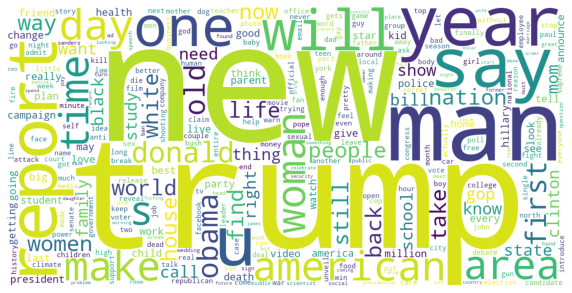

In [15]:
wc = WordCloud(background_color = "white",
               width = 1200,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 300,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1,
               )

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show

# Preprocess the dataset

In [16]:
#convert uppercase letters to lowercase letters
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#delete punctuation marks
df['text'] = df['text'].str.replace('[^\w\s]','')
#delete numbers
df['text'] = df['text'].str.replace('\d','')

C:\Users\user\AppData\Local\Temp\ipykernel_9700\3601406096.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','')
C:\Users\user\AppData\Local\Temp\ipykernel_9700\3601406096.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d','')


In [17]:
#delete stopwords
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
print("\nSTOPWORDS DELETED SUCCESFULLY...")


STOPWORDS DELETED SUCCESFULLY...


In [18]:
#lemmatization. That is, we get the roots of the words
df['text'] = df['text'].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]))
print("\nDONE SUCCESFULLY...")


DONE SUCCESFULLY...


In [19]:
df.head(10).style.background_gradient(cmap = "summer")

,text,labels
0,thirtysomething scientist unveil doomsday clock hair loss,1
1,dem rep totally nail congress falling short gender racial equality,0
2,eat veggie deliciously different recipe,0
3,inclement weather prevents liar getting work,1
4,mother come pretty close using word streaming correctly,1
5,white inheritance,0
6,way file tax le stress,0
7,richard bransons globalwarming donation nearly much cost failed balloon trip,1
8,shadow government getting large meet marriott conference room b,1
9,lot parent know scenario,0


In [20]:
x = df['text']
y = df['labels']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,shuffle = True, random_state = 11)

print(x_train.shape,x_test.shape)

(19952,) (8551,)


# Vectorize dataset with TFidfVectorizer method

In [21]:
tfid_vector = TfidfVectorizer(analyzer = 'word')
x_train = tfid_vector.fit_transform(x_train)
x_test  = tfid_vector.transform(x_test)

x_train.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.50074891, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### When 'analyzer' is set to 'word', the TfidfVectorizer will tokenize the input text into individual words and calculate the TF-IDF values for each word. Each word becomes a feature, and the vectorizer considers the importance of each word in the document and across the entire corpus.

# Build machine learning models

In [22]:
log = LogisticRegression()
log.fit(x_train,y_train)


accuracy = cross_val_score(log,x_test,y_test,cv=20).mean()

print(accuracy)

0.7490345050230909


## Xtreme gradient boosting

### XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

In [23]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train,y_train)
accuracy = cross_val_score(xgb_model,x_test,y_test,cv=20).mean()

print(accuracy)

0.710918656569415


## Light gradient boosting machines

### LightGBM extends the gradient boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients. This can result in a dramatic speedup of training and improved predictive performance. As such, LightGBM has become a de facto algorithm for machine learning competitions when working with tabular data for regression and classification predictive modeling tasks. As such, it owns a share of the blame for the increased popularity and wider adoption of gradient boosting methods in general, along with Extreme Gradient Boosting (XGBoost).

In [24]:
lgb = LGBMClassifier()
lgbm_model = lgb.fit(x_train,y_train)
accuracy = cross_val_score(lgbm_model,x_test,y_test,cv=20).mean()

print(accuracy)

[LightGBM] [Info] Number of positive: 9494, number of negative: 10458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29296
[LightGBM] [Info] Number of data points in the train set: 19952, number of used features: 1463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475842 -> initscore=-0.096707
[LightGBM] [Info] Start training from score -0.096707
[LightGBM] [Info] Number of positive: 3855, number of negative: 4268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8117
[LightGBM] [Info] Number of data points in the train set: 8123, number of used features: 500
[LightGBM] [Info] 

[LightGBM] [Info] Number of positive: 3855, number of negative: 4269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8139
[LightGBM] [Info] Number of data points in the train set: 8124, number of used features: 498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.474520 -> initscore=-0.102009
[LightGBM] [Info] Start training from score -0.102009
[LightGBM] [Info] Number of positive: 3855, number of negative: 4269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8176
[LightGBM] [Info] Number of data points in the train set: 8124, number of used features: 505
[LightGBM] [Info] [bin

## ROC AUC (Light GBM model)

### ROC AUC is a valuable metric for assessing the discriminatory power of a binary classification model, providing a concise summary of its ability to distinguish between positive and negative instances across different decision thresholds. It plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity) for various threshold values.

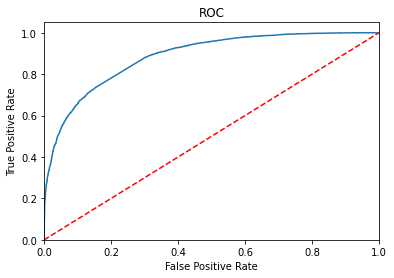

In [25]:
x = x_train.astype("float")
y = y_train

roc_auc = roc_auc_score(y, lgbm_model.predict(x))
fpr, tpr, thresholds = roc_curve(y, lgbm_model.predict_proba(x)[:,1])
plt.figure()
plt.plot(fpr,tpr,label = 'AUC(area = %0.2f)'% roc_auc)
plt.plot([0,1],[0,1],"r--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

# Estimation over test set (logistic regression model)

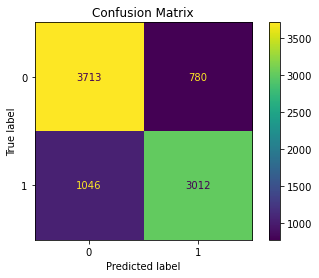

In [26]:
y_pred = log.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [27]:
print(classification_report(y_test,log.predict(x_test.astype('float'))))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      4493
           1       0.79      0.74      0.77      4058

    accuracy                           0.79      8551
   macro avg       0.79      0.78      0.79      8551
weighted avg       0.79      0.79      0.79      8551



# Build deep learning model

In [28]:
unique_words = set()
len_max = 0

for _, sent in tqdm(enumerate(x_train)):
  unique_words.update(sent.indices)
  if len_max < len(sent.indices):
    len_max =len(sent.indices)

print(len(list(unique_words)))
print(len_max)

19952it [00:02, 7771.27it/s]

21089
97


In [29]:
# tokenizer is converting text into sequences of numbers (tokens)
# num_words indicates the maximum number of words to keep based on word frequency.
tokenizer = Tokenizer(num_words = len(list(unique_words)))
# The fit_on_texts method is called to update the internal vocabulary based on the training text data (x_train). 
# This method assigns a unique integer index to each word in the vocabulary.
tokenizer.fit_on_texts([" ".join(map(str,sent)) for sent in x_train])
# The 'texts_to_sequences' method is used to convert each text in x_train and x_test into sequences of corresponding word indices. 
# Essentially, it replaces each word in the texts with its assigned integer index based on the vocabulary learned during fitting.
x_train = tokenizer.texts_to_sequences([" ".join(map(str,sent)) for sent in x_train])
x_test = tokenizer.texts_to_sequences([" ".join(map(str,sent)) for sent in x_test])
# 'sequence.pad_sequences' is employed to ensure that all sequences have the same length. 
# It pads sequences shorter than len_max and truncates sequences longer than len_max.
# This is a common practice in sequence models to ensure consistent input dimensions
x_train = sequence.pad_sequences(x_train, maxlen = len_max)
x_test = sequence.pad_sequences(x_test, maxlen = len_max)

print(x_train.shape,x_test.shape)


(19952, 97) (8551, 97)


### EarlyStopping is a callback in Keras that stops training the model when a monitored metric has stopped improving. It helps prevent overfitting and saves computational resources.

In [31]:
#min_delta: Minimum change to qualify as an improvement. 
#In this case, training will stop if the change in the monitored metric is less than 0.001.
#verbose: Controls the verbosity of the output. If set to 1, it prints a message when training stops due to early stopping.
early_stopping = EarlyStopping(min_delta = 0.001, mode = "auto", verbose = 1,
                               monitor = "val_acc",
                               patience = 3)
#Callbacks in Keras are functions that can be applied at certain stages during training.
callbacks = [early_stopping]

In [32]:
#Sequential is a linear stack of layers in Keras. It is a simple way to build a model layer by layer,
#where each layer has weights that correspond to the layer that follows it.
lstm_model = Sequential()
#Embedding layer is often used to handle word embeddings in natural language processing tasks.
# The first parameter is the input dimension
# The second parameter is the output dimension, representing the size of the embedding vector for each word.
# The 3rd parameter refers to the length of input sequence, which should match the padded sequence length.
lstm_model.add(Embedding(len(list(unique_words)), 100, input_length = len_max))
# Dropout is applied to the input units, helping prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
#This parameter is set to True because the subsequent layer (Dense(25, activation="relu")) expects sequences as input.
lstm_model.add(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = True))
#A fully connected layer with 25 units and ReLU (Rectified Linear Unit) activation function. This layer processes the output sequences from the LSTM layer.
lstm_model.add(Dense(25, activation = "relu"))
#Another dropout layer is added with a dropout rate of 0.5. This helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
lstm_model.add(Dropout(0.5))
#The final layer is a dense layer with a single unit and a sigmoid activation function.
#This is common for binary classification problems, where the output represents the probability of the positive class.
lstm_model.add(Dense(1, activation = "sigmoid"))
lstm_model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0045), metrics = ['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 97, 100)           2108900   
                                                                 
 lstm (LSTM)                 (None, 97, 64)            42240     
                                                                 
 dense (Dense)               (None, 97, 25)            1625      
                                                                 
 dropout (Dropout)           (None, 97, 25)            0         
                                                                 
 dense_1 (Dense)             (None, 97, 1)             26        
                                                                 
Total params: 2152791 (8.21 MB)
Trainable params: 2152791 (8.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Train the neural networks
# batch_size=16: This parameter defines the number of samples that will be used in each iteration of training.
# A smaller batch size can reduce memory usage and speed up training, but it may introduce more noise in the weight updates.
history = lstm_model.fit(x_train,y_train, epochs = 5, validation_data = (x_test,y_test),
                         batch_size = 16, verbose = 1, callbacks = callbacks)

Epoch 1/5



1247/1247 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.5505WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1247/1247 [==============================] - 248s 188ms/step - loss: 0.6788 - accuracy: 0.5505 - val_loss: 0.6624 - val_accuracy: 0.5689
Epoch 2/5
1247/1247 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.5909WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1247/1247 [==============================] - 231s 185ms/step - loss: 0.6357 - accuracy: 0.5909 - val_loss: 0.6664 - val_accuracy: 0.5696
Epoch 3/5
1247/1247 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.6024WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1247/1247 [==============================] - 225s 181ms/step - loss: 0.6110 - accuracy: 0.6024 - val_loss: 0.6721 - val_accuracy: 0.5685
Epoch 4/5
1247/1247 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.6069WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1247/1247 [==============================] - 225s 180ms/step - loss: 0.5985 - accuracy: 0.6069 - val_loss: 0.6937 - val_accuracy: 0.5673
Epoch 5/5
1247/1247 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.6097WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1247/1247 [==============================] - 222s 178ms/step - loss: 0.5908 - accuracy: 0.6097 - val_loss: 0.7232 - val_accuracy: 0.5658


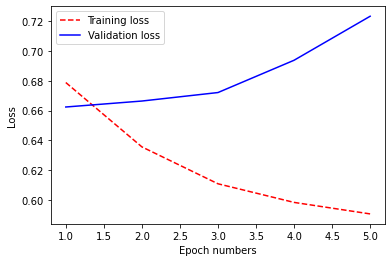

In [34]:
epoch_num = range(1, len(history.history["loss"]) + 1)
plt.plot(epoch_num, history.history["loss"], "r--")
plt.plot(epoch_num, history.history["val_loss"], "b-")
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Epoch numbers")
plt.ylabel("Loss")
plt.show()